# PRÁCTICA FINAL
## SIGNATURA: Machine Learning
### Autor: Lucía Saiz Lapique, Raquel Fort Serra, María Carrasco Meléndez 


## Introducción:

En los últimos diez años, han sido numerosos los incendios que han tenido lugar en la Amazonía, especialmente durante la estación seca, y en su mayoría iniciados deliberadamente con el fin de desforestar ilegalmente las tierras para la cría de ganado. La destrucción de la Amazonía en Brasil se ha incrementado rápidamente desde que el nuevo presidente brasileño, Jair Bolsonaro, de extrema derecha, asumió el cargo y su gobierno redujo los esfuerzos para combatir la tala, la ganadería y la minería ilegales. 

Estos incendios continuados se han convertido en un negocio millonario, prenderle fuego a un área de mil hectáreas equivale a unos 220 000 €. El bosque amazónico tiene un gran impacto en el ecosistema, dentro pero también fuera de la región amazónica ya que despierta los intereses tanto del comercio internacional como del mercado financiero. Mientras el primero busca una mayor producción de carne y soja, empresas y fondos de inversión muestran su preocupación por el impacto financiero que la deforestación en la Amzonia pueda tener en las empresas, lo que podría aumentar los riesgos de reputación, operatorios y regulatorios. 

Este estudio pretende plantear las posibles relaciones causales que puedan existir entre esta sucesión de incendios y su repercusión económica, concretamente en el Producto Interior Bruto (PIB), el Índice de Precios al Consumo (CPI), el desempleo y la población. 


## Problema de negocio: KPI 

En base a nuestro criterio, se espera que los incendios tengan un impacto directo en estas variables económicas


In [1]:
# importamos las librerias necesarias para el estudio
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from matplotlib import pyplot
from sklearn.metrics import r2_score # R^2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.preprocessing import StandardScaler # estandarization
from math import sqrt # sqrt
import random
from IPython.core.pylabtools import figsize

sns.set_style("whitegrid")
sns.set_palette("colorblind")

from sklearn.utils import resample
import dowhy
from dowhy import CausalModel
from causalimpact import CausalImpact

In [2]:
# cargamos las bases de datos
fuegos = pd.read_csv('./data/fuegos_brasil.csv')
desempleo = pd.read_csv('./data/desempleo.csv')
cpi = pd.read_csv('./data/cpi.csv')
pib = pd.read_csv('./data/pib.csv')
poblacion = pd.read_csv('./data/poblacion3.csv', delimiter = ';', index_col = 0)

## Análisis descriptivo 

Los datos están compuestos por una recopilación de cinco bases de datos distintas, de donde se recogen dos variables principales de cada una: la principal de cada base de datos y su fecha asociada. Las dos primeras variables explicadas a continuación son comunes en todos los análisis causales que se van a desarrollar en el presente estudio.
* Incendios: Esta variable hace referencia al número de incendios.
* Fecha: dividida por año y mes, se incluyen datos que van desde el 2005 al 2015
* PIB: Producto Interior Bruto 
* CPI: Índice de precios al consumidor
* Desempleo: Tasa de desempleo 
* Población: Número total de habitantes


## EDA 

Para tratar las cinco bases de datos con las que contamos, seguimos una serie de pasos comunes para todas ellas con la finalidad de poder combinar la base de datos que hace referencia a los incendios en Brasil en los últimos 10 años con todos los paremetros de forma individual.

Por una parte, la base de datos que hace referencia a los incendios contaba con diversas columnas que indicaban la ubicación de cada incendio nque se ha decidido eliminar, ya que solo nos interesaba la fecha y el número de incendios. Así mismo se ha decidido descartar algunas observaciones con el fin de estudiar únicamente el impacto de los últimos 10 años. Para series temporales las predicciones resultan más fáciles y efectivas sobre meses que sobre días, es por este motivo por el que se ha decidido transformar los datos diarios a mensuales. 

Para el PIB, CPI y Desempleo se ha llevado el mismo procedimiento; separamos la fecha por año y mes, y a continuación unimos cada una de ellas a la base de datos de incendios de forma independiente con el fin de estudiarlas por separado. 


### Base de datos desempleo

In [3]:
desempleo.head()

,DATE,LRUNTTTTBRM156S
0,2005-11-01,10.109956
1,2005-12-01,9.675369
2,2006-01-01,9.617917
3,2006-02-01,9.895424
4,2006-03-01,9.872679


In [4]:
desempleo.count()

DATE               121
LRUNTTTTBRM156S    121
dtype: int64

In [5]:
desempleo = desempleo.rename(columns = {'LRUNTTTTBRM156S':'Tasa'})
desempleo.Tasa = round(desempleo.Tasa, 2)
desempleo.head()

,DATE,Tasa
0,2005-11-01,10.11
1,2005-12-01,9.68
2,2006-01-01,9.62
3,2006-02-01,9.90
4,2006-03-01,9.87


In [6]:
fechas = desempleo.DATE.str.split("-", expand = True)
fechas.pop(2)
fechas.head()

,0,1
0,2005,11
1,2005,12
2,2006,01
3,2006,02
4,2006,03


In [7]:
desempleo = pd.concat([desempleo, fechas], axis = 1, sort = False)
desempleo.pop('DATE')
desempleo = desempleo.rename(columns = {0:'year', 1: 'month'})
desempleo.head()

,Tasa,year,month
0,10.11,2005,11
1,9.68,2005,12
2,9.62,2006,01
3,9.90,2006,02
4,9.87,2006,03


In [8]:
desempleo['Fecha'] = desempleo.year + desempleo.month
desempleo.head()

,Tasa,year,month,Fecha
0,10.11,2005,11,200511
1,9.68,2005,12,200512
2,9.62,2006,01,200601
3,9.90,2006,02,200602
4,9.87,2006,03,200603


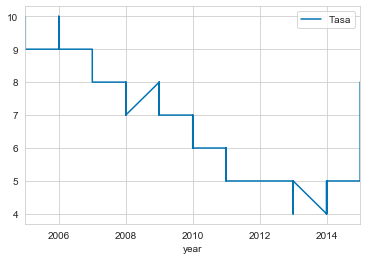

In [89]:
desempleo.year = np.int64(desempleo.year)
desempleo.plot('year', 'Tasa')

### Base de datos CPI

In [10]:
cpi.head()

,DATE,BRACPIALLMINMEI
0,2005-11-01,58.613449
1,2005-12-01,58.824348
2,2006-01-01,59.171438
3,2006-02-01,59.414123
4,2006-03-01,59.669568


In [11]:
cpi = cpi.rename(columns = {'BRACPIALLMINMEI':'CPI'})
cpi.CPI = round(cpi.CPI, 2)
cpi.head()

,DATE,CPI
0,2005-11-01,58.61
1,2005-12-01,58.82
2,2006-01-01,59.17
3,2006-02-01,59.41
4,2006-03-01,59.67


In [12]:
fechas2 = cpi.DATE.str.split("-", expand = True)
fechas2 = fechas2.rename(columns = {0: 'year', 1: 'month'})
fechas2.pop(2)
fechas2.head()

,year,month
0,2005,11
1,2005,12
2,2006,01
3,2006,02
4,2006,03


In [13]:
cpi = pd.concat([cpi, fechas2], axis = 1, sort = False)
cpi.pop('DATE')
cpi.head()

,CPI,year,month
0,58.61,2005,11
1,58.82,2005,12
2,59.17,2006,01
3,59.41,2006,02
4,59.67,2006,03


In [14]:
cpi['Fecha'] = cpi.year + cpi.month
cpi.head()

,CPI,year,month,Fecha
0,58.61,2005,11,200511
1,58.82,2005,12,200512
2,59.17,2006,01,200601
3,59.41,2006,02,200602
4,59.67,2006,03,200603


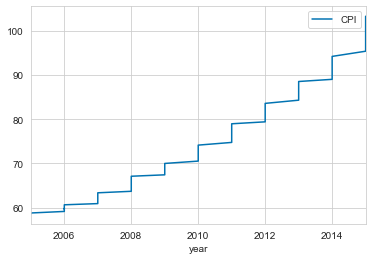

In [90]:
cpi.year = np.int64(cpi.year)
cpi.plot('year', 'CPI')

### Base de datos PIB

In [16]:
pib.head()

,DATE,BRALORSGPNOSTSAM
0,2005-11-01,99.257355
1,2005-12-01,99.264442
2,2006-01-01,99.288699
3,2006-02-01,99.303834
4,2006-03-01,99.294399


In [17]:
pib = pib.rename(columns = {'BRALORSGPNOSTSAM':'PIB'})
pib.PIB = round(pib.PIB, 2)
pib.head()

,DATE,PIB
0,2005-11-01,99.26
1,2005-12-01,99.26
2,2006-01-01,99.29
3,2006-02-01,99.30
4,2006-03-01,99.29


In [18]:
fechas3 = pib.DATE.str.split("-", expand = True)
fechas3 = fechas3.rename(columns = {0: 'year', 1: 'month'})
fechas3.pop(2)
fechas3.head()

,year,month
0,2005,11
1,2005,12
2,2006,01
3,2006,02
4,2006,03


In [19]:
pib = pd.concat([pib, fechas3], axis = 1, sort = False)
pib.pop('DATE')
pib.head()

,PIB,year,month
0,99.26,2005,11
1,99.26,2005,12
2,99.29,2006,01
3,99.30,2006,02
4,99.29,2006,03


In [20]:
pib['Fecha'] = pib.year + pib.month
pib.head()

,PIB,year,month,Fecha
0,99.26,2005,11,200511
1,99.26,2005,12,200512
2,99.29,2006,01,200601
3,99.30,2006,02,200602
4,99.29,2006,03,200603


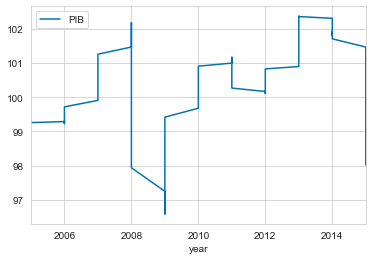

In [91]:
pib.year = np.int64(pib.year)
pib.plot('year', 'PIB')

### Base de datos población

In [22]:
poblacion.pop('Unnamed: 4')
poblacion.pop('Unnamed: 5')
poblacion.pop('Unnamed: 6')
poblacion.pop('Unnamed: 7')
poblacion.pop('Unnamed: 8')
poblacion.pop('Unnamed: 9')
poblacion.pop('Unnamed: 10')
poblacion.pop('Unnamed: 11')
poblacion.pop('Unnamed: 12')
poblacion

,month,year,Total
0,1,2005,186127103
1,2,2005,186127103
2,3,2005,186127103
3,4,2005,186127103
4,5,2005,186127103
...,...,...,...
127,8,2015,204471769
128,9,2015,204471769
129,10,2015,204471769
130,11,2015,204471769


In [26]:
poblacion.drop(poblacion[(poblacion.year == 2005) & (poblacion.month < 11)].index, inplace = True)

In [27]:
poblacion['year'] = poblacion['year'].astype(str)
poblacion['month'] = poblacion['month'].astype(str)

In [28]:
poblacion['month'] = np.where(poblacion['month'] == '1', '01', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '2', '02', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '3', '03', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '4', '04', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '5', '05', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '6', '06', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '7', '07', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '8', '08', poblacion['month'].values)
poblacion['month'] = np.where(poblacion['month'] == '9', '09', poblacion['month'].values)

In [29]:
poblacion['Fecha'] = poblacion.year + poblacion.month
poblacion.head()

,month,year,Total,Fecha
10,11,2005,186127103,200511
11,12,2005,186127103,200512
12,01,2006,188167356,200601
13,02,2006,188167356,200602
14,03,2006,188167356,200603


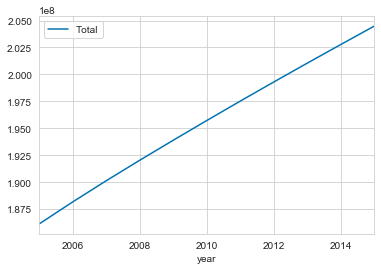

In [92]:
poblacion.year = np.int64(poblacion.year)
poblacion.plot('year', 'Total')

### Base de datos fuegos

In [30]:
fuegos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 6 columns):
year         2104 non-null int64
month        2104 non-null int64
state        2104 non-null object
latitude     2104 non-null float64
longitude    2104 non-null float64
firespots    2104 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 98.8+ KB


In [31]:
fuegos.head()

,year,month,state,latitude,longitude,firespots
0,1999,1,AMAZONAS,-2.371113,-59.899933,3
1,1999,1,MARANHAO,-2.257395,-45.487831,36
2,1999,1,MATO GROSSO,-12.660633,-55.057989,18
3,1999,1,PARA,-2.474820,-48.546967,87
4,1999,1,RONDONIA,-12.861700,-60.513100,1


In [32]:
fuegos.drop(["state", "latitude", "longitude"], axis = 1, inplace = True)

In [33]:
fuegos.drop(fuegos[fuegos.year < 2005].index, inplace = True)

In [34]:
fuegos.drop(fuegos[(fuegos.year == 2005) & (fuegos.month < 11)].index, inplace = True)

In [35]:
fuegos.sort_values(by = ['year', 'month'], ascending = True)

,year,month,firespots
644,2005,11,27
645,2005,11,1054
646,2005,11,833
647,2005,11,3498
648,2005,11,1136
...,...,...,...
2099,2019,12,148
2100,2019,12,1280
2101,2019,12,42
2102,2019,12,27


In [36]:
fuegos['year'] = fuegos['year'].astype(str)
fuegos['month'] = fuegos['month'].astype(str)

In [37]:
fuegos.month.unique()

array(['11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
      dtype=object)

In [38]:
fuegos['month'] = np.where(fuegos['month'] == '1', '01', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '2', '02', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '3', '03', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '4', '04', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '5', '05', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '6', '06', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '7', '07', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '8', '08', fuegos['month'].values)
fuegos['month'] = np.where(fuegos['month'] == '9', '09', fuegos['month'].values)

In [39]:
fuegos.month.unique()

array(['11', '12', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10'], dtype=object)

In [40]:
fuegos['Fecha'] = fuegos.year + fuegos.month

In [41]:
fuegos_grupo = pd.DataFrame(fuegos.groupby(['year', 'month', 'Fecha']).sum())
fuegos_grupo.head()

firespots
year month Fecha            
2005 11    200511      16790
     12    200512       6966
2006 01    200601       1973
     02    200602        879
     03    200603        903

In [42]:
fuegos_grupo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 170 entries, (2005, 11, 200511) to (2019, 12, 201912)
Data columns (total 1 columns):
firespots    170 non-null int64
dtypes: int64(1)
memory usage: 3.7+ KB


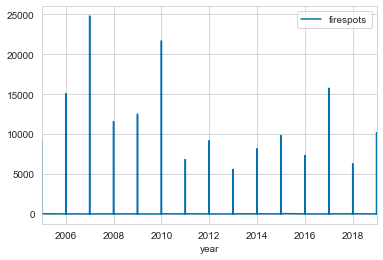

In [93]:
fuegos.year = np.int64(fuegos.year)
fuegos.plot('year', 'firespots')

## BBDD finales

In [44]:
fueg_desemp = pd.merge(fuegos_grupo, desempleo, on = 'Fecha', how = 'inner')
fueg_desemp.pop('Fecha')
fueg_desemp

,firespots,Tasa,year,month
0,16790,10.11,2005,11
1,6966,9.68,2005,12
2,1973,9.62,2006,01
3,879,9.90,2006,02
4,903,9.87,2006,03
...,...,...,...,...
116,2817,7.31,2015,07
117,20471,7.44,2015,08
118,29326,7.54,2015,09
119,19469,8.00,2015,10


In [45]:
np.corrcoef(fueg_desemp['firespots'], fueg_desemp['Tasa'])

array([[1.        , 0.17902051],
       [0.17902051, 1.        ]])

Entre la tasa de desempleo y el número de incendios en los últimos años, existe un 18% de correlación. 

In [46]:
fueg_desemp = fueg_desemp[['Tasa', 'firespots', 'year', 'month']]
fueg_desemp.head()

,Tasa,firespots,year,month
0,10.11,16790,2005,11
1,9.68,6966,2005,12
2,9.62,1973,2006,01
3,9.90,879,2006,02
4,9.87,903,2006,03


In [47]:
fueg_cpi = pd.merge(fuegos_grupo, cpi, on = 'Fecha', how = 'inner')
fueg_cpi.pop('Fecha')
fueg_cpi = fueg_cpi[['CPI', 'firespots', 'year', 'month']]
fueg_cpi

,CPI,firespots,year,month
0,58.61,16790,2005,11
1,58.82,6966,2005,12
2,59.17,1973,2006,01
3,59.41,879,2006,02
4,59.67,903,2006,03
...,...,...,...,...
116,100.63,2817,2015,07
117,100.85,20471,2015,08
118,101.39,29326,2015,09
119,102.22,19469,2015,10


In [48]:
np.corrcoef(fueg_cpi['firespots'], fueg_cpi['CPI'])

array([[ 1.        , -0.11364116],
       [-0.11364116,  1.        ]])

Entre la tasa de inflación y el número de incendios en los últimos años, existe un -11% de correlación. 

In [49]:
fueg_pib = pd.merge(fuegos_grupo, pib, on = 'Fecha', how = 'inner')
fueg_pib.pop('Fecha')
fueg_pib = fueg_pib[['PIB', 'firespots', 'year', 'month']]
fueg_pib

,PIB,firespots,year,month
0,99.26,16790,2005,11
1,99.26,6966,2005,12
2,99.29,1973,2006,01
3,99.30,879,2006,02
4,99.29,903,2006,03
...,...,...,...,...
116,99.03,2817,2015,07
117,98.70,20471,2015,08
118,98.43,29326,2015,09
119,98.21,19469,2015,10


In [50]:
np.corrcoef(fueg_pib['firespots'], fueg_pib['PIB'])

array([[ 1.        , -0.05197448],
       [-0.05197448,  1.        ]])

Entre el producto interior bruto y el número de incendios en los últimos años, existe un 5,2% de correlación. 

In [51]:
fueg_pob = pd.merge(fuegos_grupo, poblacion, on = 'Fecha', how = 'inner')
fueg_pob.pop('Fecha')
fueg_pob = fueg_pob[['Total', 'firespots', 'year', 'month']]
fueg_pob

,Total,firespots,year,month
0,186127103,16790,2005,11
1,186127103,6966,2005,12
2,188167356,1973,2006,01
3,188167356,879,2006,02
4,188167356,903,2006,03
...,...,...,...,...
117,204471769,20471,2015,08
118,204471769,29326,2015,09
119,204471769,19469,2015,10
120,204471769,16935,2015,11


In [52]:
np.corrcoef(fueg_pob['firespots'], fueg_pob['Total'])

array([[ 1.        , -0.16611381],
       [-0.16611381,  1.        ]])

Entre la población y el número de incendios en los últimos años, existe un -17,04% de correlación. 

## Estudio causalidad

## Impacto causal entre PIB e incendios

En primer lugar, debemos tener todos los obejetos de tipo numérico para poder aplicar el modelo. Se observa que las variables "month" y "year" no lo son, así que se procede en primer lugar a su conversión.

In [53]:
#!pip install pycausalimpact
fueg_pib.year = np.int64(fueg_pib.year)
fueg_pib.month = np.int64(fueg_pib.month)

Para estimar un efecto causal, comenzamos especificando qué período en los datos debe usarse para entrenar el modelo (período previo a la intervención) y qué período para calcular una predicción contrafactual (período posterior a la intervención). 
De esta forma se decide utilizar los 90 primeros meses para el entrenamiento y los últimos 30 meses se utilizarán en la obtención de predicciones. 

In [54]:
random.seed(123)
pre_period = [0, 90]
post_period = [91, 120]
ci_pib = CausalImpact(fueg_pib, pre_period, post_period, prior_level_sd = None)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Con esta función "CausalImpact()", se ejecuta un modelo de serie temporal estructural, se realiza la inferencia posterior y calcula estimaciones del efecto causal. 

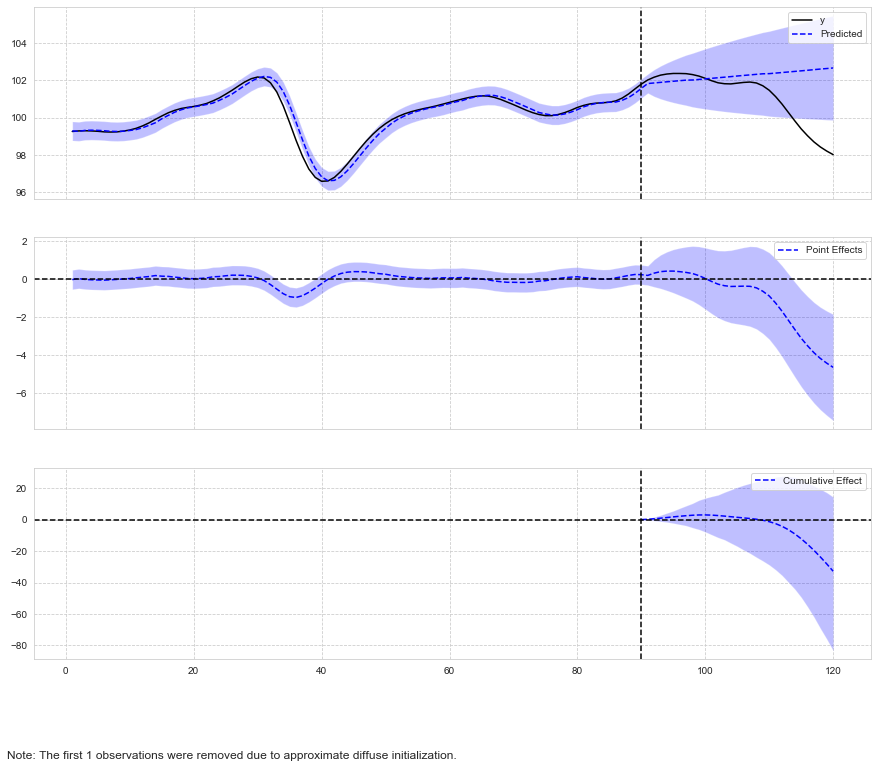

In [55]:
ci_pib.plot()

El gráfico contiene tres paneles. El primero muestra los datos junto con la predicción contrafactual con los datos del período posterior al tratamiento. 
El segundo panel muestra la diferencia entre los datos observados y las predicciones contrafácticas. Este es el efecto causal puntual, según lo estimado por el modelo. 
El tercer panel suma las contribuciones puntuales del segundo panel, lo que resulta en una gráfica del efecto acumulativo de la intervención.

In [56]:
print(ci_pib.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    101.15             3034.49
Prediction (s.d.)         102.24 (0.83)      3067.32 (24.94)
95% CI                    [100.67, 103.93]   [3020.09, 3117.84]

Absolute effect (s.d.)    -1.09 (0.83)       -32.83 (24.94)
95% CI                    [-2.78, 0.48]      [-83.35, 14.4]

Relative effect (s.d.)    -1.07% (0.81%)     -1.07% (0.81%)
95% CI                    [-2.72%, 0.47%]    [-2.72%, 0.47%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 91.71%

For more details run the command: print(impact.summary('report'))


La columna "Average" habla sobre el promedio (a través del tiempo) durante el período posterior a la intervención (últimos 30 meses). La columna acumulativa ("Cumulative") resume puntos de tiempo individuales, que es una perspectiva útil si la variable de respuesta representa una cantidad de flujo (como consultas, clics, visitas, instalaciones, ventas o ingresos) en lugar de una cantidad de existencias (como el número de usuarios o precio de mercado).

Podemos observar que el efecto causal promedio estimado del tratamiento fue de -1.09. El intervalo posterior del 95% del efecto promedio es [-2.7, 0.44]. Como esto incluye 0, concluimos que la intervención no tuvo un efecto causal en la variable de respuesta.

In [57]:
print(ci_pib.summary(output='report'))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 101.15. In the absence of an
intervention, we would have expected an average response of 102.24.
The 95% interval of this counterfactual prediction is [100.67, 103.93].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1.09 with a 95% interval of
[-2.78, 0.48]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3034.49.
Had the intervention not taken place, we would have expected
a sum of 3067.32. The 95% interval of this prediction is [3020.09, 3117.84].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decreas

El efecto aparente podría ser el resultado de fluctuaciones aleatorias que no están relacionados con la intervención. Este suele darse cuando el período de intervención es muy largo e incluye la mayor parte del tiempo, cuando el efecto ya ha desaparecido. También puede ser el caso cuando el período de intervención es demasiado corto para distinguir la señal de ruido. Finalmente, no encontrar un efecto significativo puede ocurrir cuando no hay suficientes variables de control o cuando estas variables no se correlacionan bien con la variable de respuesta durante el período de aprendizaje.
La probabilidad de obtener este efecto por casualidad es p = 8.69%. Esto significa que el efecto puede ser engañoso y generalmente no sería considerado estadísticamente significativo.

In [58]:
ci_pib.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,98.832591,NaN,NaN,NaN,-2389.613880,2587.279062,NaN,NaN,NaN,0.427409,-2488.019062,2488.873880,NaN,NaN,NaN
1,NaN,99.288428,NaN,NaN,NaN,98.778273,99.798583,NaN,NaN,NaN,-0.028428,-0.538583,0.481727,NaN,NaN,NaN
2,NaN,99.267525,NaN,NaN,NaN,98.757370,99.777680,NaN,NaN,NaN,0.022475,-0.487680,0.532630,NaN,NaN,NaN
3,NaN,99.319970,NaN,NaN,NaN,98.809815,99.830125,NaN,NaN,NaN,-0.019970,-0.530125,0.490185,NaN,NaN,NaN
4,NaN,99.330168,NaN,NaN,NaN,98.820013,99.840323,NaN,NaN,NaN,-0.040168,-0.550323,0.469987,NaN,NaN,NaN


## Impacto causal entre CPI e incendios

En primer lugar, convertimos a integer nuestras variables 'year' y 'month' para poder utilizarlos en el modelo.

In [59]:
fueg_cpi.year = np.int64(fueg_cpi.year)
fueg_cpi.month = np.int64(fueg_cpi.month)

Repetimos la misma acción para la inflación. Especificamos en los datos que periodo debe utilizarse tanto para entrenar al modelo como el contrafactual; empleando 90 meses para el entrenamiento y los restantes 30 para obtener predicciones.

In [60]:
random.seed(123)
pre_period2 = [0, 90]
post_period2 = [91, 120]
ci_cpi = CausalImpact(fueg_cpi, pre_period2, post_period2, prior_level_sd = None)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


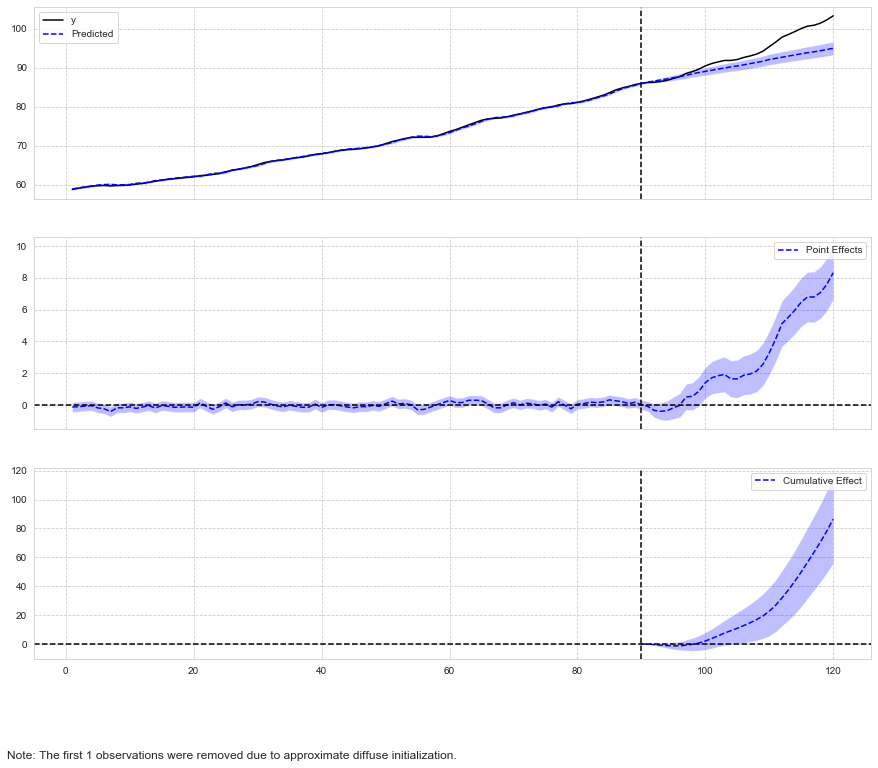

In [61]:
ci_cpi.plot()

In [62]:
print(ci_cpi.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    93.52              2805.48
Prediction (s.d.)         90.64 (0.51)       2719.08 (15.33)
95% CI                    [89.65, 91.65]     [2689.39, 2749.5]

Absolute effect (s.d.)    2.88 (0.51)        86.4 (15.33)
95% CI                    [1.87, 3.87]       [55.98, 116.09]

Relative effect (s.d.)    3.18% (0.56%)      3.18% (0.56%)
95% CI                    [2.06%, 4.27%]     [2.06%, 4.27%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Podemos observar que el efecto causal promedio estimado del tratamiento fue de 2.88. El intervalo posterior del 95% del efecto promedio es [1.91, 3.88] . Como esto excluye 0, concluimos que la intervención tuvo un efecto causal en la variable de respuesta.

In [63]:
print(ci_cpi.summary(output='report'))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 93.52. By contrast, in the absence of an
intervention, we would have expected an average response of 90.64.
The 95% interval of this counterfactual prediction is [89.65, 91.65].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.88 with a 95% interval of
[1.87, 3.87]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2805.48.
By contrast, had the intervention not taken place, we would have expected
a sum of 2719.08. The 95% interval of this prediction is [2689.39, 2749.5].


The above results are given in terms of absolute numbers. In relative
terms, the response variab

Esto significa que el efecto positivo observado durante la intervención el período es estadísticamente significativo y es poco probable que se deba a un azar fluctuaciones. La probabilidad de área de cola unilateral bayesiana p = 0.0.
Esto significa que el efecto causal puede considerarse estadísticamente significativo.

In [64]:
ci_cpi.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,56.472127,NaN,NaN,NaN,-15712.130948,15825.075203,NaN,NaN,NaN,2.137873,-15766.465203,15770.740948,NaN,NaN,NaN
1,NaN,58.934618,NaN,NaN,NaN,58.628408,59.240829,NaN,NaN,NaN,-0.114618,-0.420829,0.191592,NaN,NaN,NaN
2,NaN,59.266781,NaN,NaN,NaN,58.960571,59.572992,NaN,NaN,NaN,-0.096781,-0.402992,0.209429,NaN,NaN,NaN
3,NaN,59.464873,NaN,NaN,NaN,59.158663,59.771084,NaN,NaN,NaN,-0.054873,-0.361084,0.251337,NaN,NaN,NaN
4,NaN,59.701064,NaN,NaN,NaN,59.394854,60.007274,NaN,NaN,NaN,-0.031064,-0.337274,0.275146,NaN,NaN,NaN


## Impacto causal entre desempleo e incendios

En primer lugar, convertimos a integer nuestras variables 'year' y 'month' para poder utilizarlos en el modelo.

In [65]:
fueg_desemp.year = np.int64(fueg_desemp.year)
fueg_desemp.month = np.int64(fueg_desemp.month)

Repetimos la misma acción para el desempleo. Especificamos en los datos que periodo debe utilizarse tanto para entrenar al modelo como el contrafactual; empleando 90 meses para el entrenamiento y los restantes 30 para obtener predicciones.

In [66]:
random.seed(123)
pre_period3 = [0, 90]
post_period3 = [91, 120]
ci_des = CausalImpact(fueg_desemp, pre_period3, post_period3, prior_level_sd = None)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


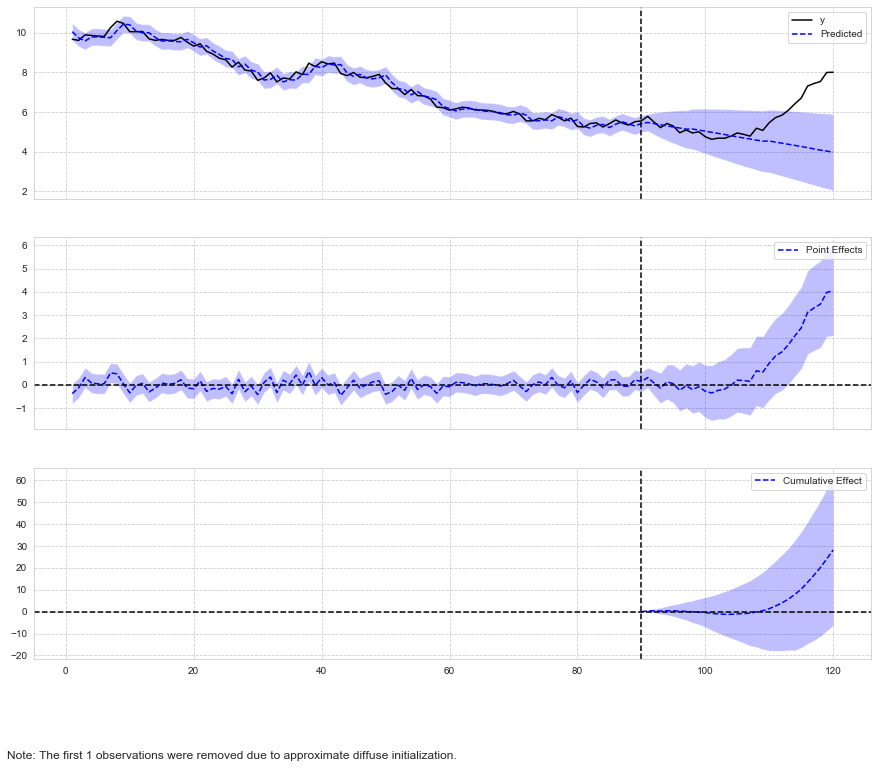

In [67]:
ci_des.plot()

In [68]:
print(ci_des.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5.67               170.03
Prediction (s.d.)         4.73 (0.58)        141.86 (17.41)
95% CI                    [3.6, 5.88]        [108.14, 176.4]

Absolute effect (s.d.)    0.94 (0.58)        28.17 (17.41)
95% CI                    [-0.21, 2.06]      [-6.37, 61.89]

Relative effect (s.d.)    19.86% (12.27%)    19.86% (12.27%)
95% CI                    [-4.49%, 43.63%]   [-4.49%, 43.63%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 94.11%

For more details run the command: print(impact.summary('report'))


Podemos observar que el efecto causal promedio estimado del tratamiento fue de 0.94. El intervalo posterior del 95% del efecto promedio es [-0.17, 2.1] . Como esto incluye 0, concluimos que la intervención no tuvo un efecto causal en la variable de respuesta.

In [69]:
print(ci_des.summary(output='report'))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5.67. In the absence of an
intervention, we would have expected an average response of 4.73.
The 95% interval of this counterfactual prediction is [3.6, 5.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.94 with a 95% interval of
[-0.21, 2.06]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 170.03.
Had the intervention not taken place, we would have expected
a sum of 141.86. The 95% interval of this prediction is [108.14, 176.4].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +19.86%. 

La probabilidad de obtener este efecto por casualidad es p = 5.09%. Esto significa que el efecto puede ser espurio y generalmente no lo sería considerado estadísticamente significativo.

In [70]:
ci_des.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,9.837850,NaN,NaN,NaN,-3205.804592,3225.480292,NaN,NaN,NaN,0.272150,-3215.370292,3215.914592,NaN,NaN,NaN
1,NaN,10.059506,NaN,NaN,NaN,9.628853,10.490158,NaN,NaN,NaN,-0.379506,-0.810158,0.051147,NaN,NaN,NaN
2,NaN,9.751679,NaN,NaN,NaN,9.327431,10.175927,NaN,NaN,NaN,-0.131679,-0.555927,0.292569,NaN,NaN,NaN
3,NaN,9.588302,NaN,NaN,NaN,9.164250,10.012354,NaN,NaN,NaN,0.311698,-0.112354,0.735750,NaN,NaN,NaN
4,NaN,9.789175,NaN,NaN,NaN,9.365129,10.213220,NaN,NaN,NaN,0.080825,-0.343220,0.504871,NaN,NaN,NaN


## Impacto causal entre población e incendios

En primer lugar, convertimos a integer nuestras variables 'year' y 'month' para poder utilizarlos en el modelo.

In [71]:
fueg_pob.year = np.int64(fueg_pob.year)
fueg_pob.month = np.int64(fueg_pob.month)

In [72]:
fueg_pob.count()

Total        122
firespots    122
year         122
month        122
dtype: int64

Repetimos la misma acción para la población. Especificamos en los datos que periodo debe utilizarse tanto para entrenar al modelo como el contrafactual; empleando 90 meses para el entrenamiento y los restantes 30 para obtener predicciones.

In [73]:
random.seed(123)
pre_period4 = [0, 90]
post_period4 = [91,120]
ci_pob = CausalImpact(fueg_pob, pre_period4, post_period4, prior_level_sd = None)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


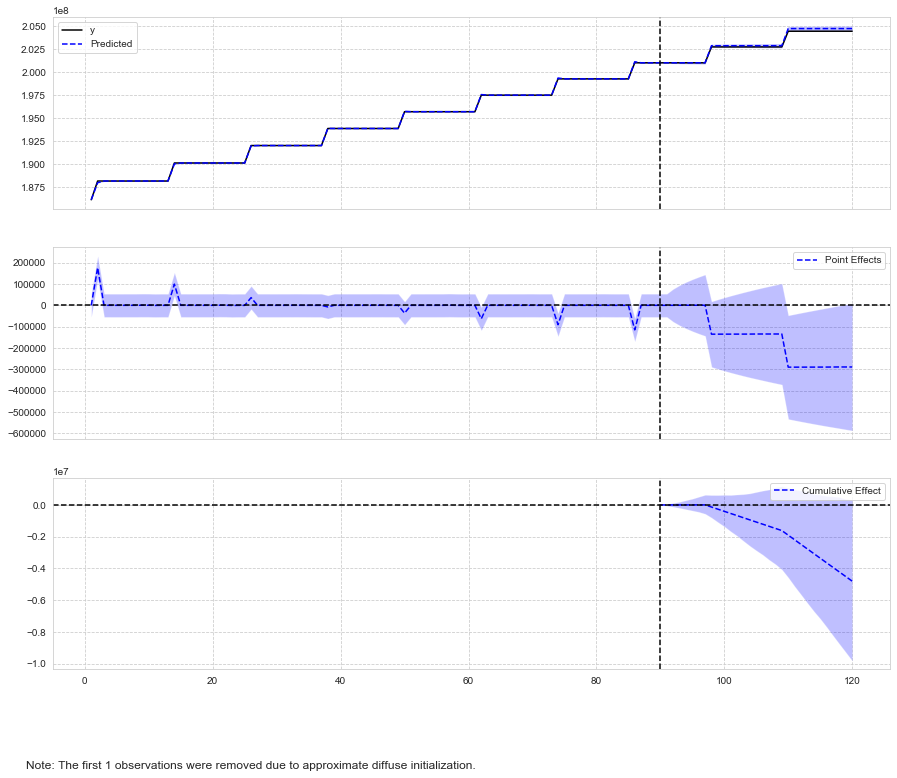

In [74]:
ci_pob.plot()

In [75]:
print(ci_pob.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    202986853.33       6089605600.0
Prediction (s.d.)         203146809.03 (86233.46)6094404270.8 (2587003.66)
95% CI                    [202975839.74, 203313868.68][6089275192.35, 6099416060.35]

Absolute effect (s.d.)    -159955.69 (86233.46)-4798670.8 (2587003.66)
95% CI                    [-327015.34, 11013.59][-9810460.35, 330407.65]

Relative effect (s.d.)    -0.08% (0.04%)     -0.08% (0.04%)
95% CI                    [-0.16%, 0.01%]    [-0.16%, 0.01%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 96.7%

For more details run the command: print(impact.summary('report'))


Podemos observar que el efecto causal promedio estimado del tratamiento fue de -159955.69. El intervalo posterior del 95% del efecto promedio es [-338644.64, 23708.44]. Como esto incluye 0, concluimos que la intervención tuvo un efecto causal en la variable de respuesta.

In [76]:
print(ci_pob.summary(output='report'))


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 202986853.33. In the absence of an
intervention, we would have expected an average response of 203146809.03.
The 95% interval of this counterfactual prediction is [202975839.74, 203313868.68].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -159955.69 with a 95% interval of
[-327015.34, 11013.59]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6089605600.0.
Had the intervention not taken place, we would have expected
a sum of 6094404270.8. The 95% interval of this prediction is [6089275192.35, 6099416060.35].


The above results are given in terms of absolute number

La probabilidad de obtener este efecto por casualidad es p = 0.05. Esto significa que el efecto puede ser espurio y generalmente no lo sería considerado estadísticamente significativo.

In [77]:
ci_pob.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,1.863490e+08,NaN,NaN,NaN,-7.836717e+09,8.209415e+09,NaN,NaN,NaN,-221885.909589,-8.023288e+09,8.022844e+09,NaN,NaN,NaN
1,NaN,1.861272e+08,NaN,NaN,NaN,1.860728e+08,1.861816e+08,NaN,NaN,NaN,-66.846216,-5.447240e+04,5.433871e+04,NaN,NaN,NaN
2,NaN,1.879907e+08,NaN,NaN,NaN,1.879363e+08,1.880451e+08,NaN,NaN,NaN,176667.768320,1.222621e+05,2.310734e+05,NaN,NaN,NaN
3,NaN,1.881672e+08,NaN,NaN,NaN,1.881128e+08,1.882216e+08,NaN,NaN,NaN,141.530370,-5.426410e+04,5.454716e+04,NaN,NaN,NaN
4,NaN,1.881673e+08,NaN,NaN,NaN,1.881129e+08,1.882217e+08,NaN,NaN,NaN,68.847107,-5.433678e+04,5.447447e+04,NaN,NaN,NaN


## Conclusión:

Para concluir este estudio, vemos como el único índice que tiene una relación de causalidad con los incendios ocurridos en Brasil en los últimos 10 años es el CPI. A continuación, se genera una posible interpretación de estos resultados aplicados a la economía del país.

La relación entre ambos puede deberse a que, debido a los incendios, se pierden recursos en varios sectores, principalmente el de la agricultura. De esta forma, el índice de Precios al Consumo se ve afectado porque el precio de estos productos incrementan y cambian los hábitos de consumo de la población. 

Vemos además que este hecho ha enviado a la moneda brasileña a su nivel más bajo en 12 años respecto del dólar. 

En el caso de los demás índices, cabe mencionar también por qué no resultan estar relacionados a los incendios. En el caso de la población, se ve como crece progresivamente con los años, sin verse influenciada por otros aspectos. En el caso del PIB y el desempleo, nos han sorprendido los resultados pues la hipótesis inicial era que sí habría una relación causal importante entre ellos. 

## Bibliografía:

* __World Bank__, _Population, Total for Brazil_ [POPTOTBRA647NWDB], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/POPTOTBRA647NWDB, January 31, 2020.
* __Organization for Economic Co-operation and Development,__ _Consumer Price Index: All Items for Brazil_ [BRACPIALLMINMEI], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/BRACPIALLMINMEI, January 31, 2020.
* __Organization for Economic Co-operation and Development__, _Unemployment Rate: Aged 15 and Over: All Persons for Brazil_ [LRUNTTTTBRM156S], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/LRUNTTTTBRM156S, January 31, 2020.
* __Organization for Economic Co-operation and Development__, _Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for Brazil_ [BRALORSGPNOSTSAM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/BRALORSGPNOSTSAM, January 31, 2020.
* __K. H. Brodersen, A. Hauser__ (2017). _CausalImpact: An R package for causal inference using Bayesian structural time-series models._ Retrieved from GitHub. URL: https://google.github.io/CausalImpact/CausalImpact.html#working-with-dates-and-times
* __J. Corellano__ (2019). _INCENDIOS BRASIL_. Lo que se esconde tras los incendios de la Amazonia: es el mercado, amigo. Retrieved from Público. URL: https://www.publico.es/sociedad/incendios-brasil-esconde-incendios-amazonia-mercado-amigo.html
* __A. Benites__ (2019). _El millonario negocio de los incendios en la Amazonia_. Retrieved from EL PAÍs. URL: https://elpais.com/internacional/2019/08/27/actualidad/1566864699_526443.html
* __A. Castedo__ (2019). _Incendios en el Amazonas: quién se beneficia de la explotación económica de la Amazonía brasileña_. Retrieved from BBC. URL: https://www.bbc.com/mundo/noticias-america-latina-49514582
* __A. Symonds__ (2019). _Lo que debes saber sobre el incendio en la Amazonía_. Retrieved from The New York Times; América del Sur. URL: https://www.nytimes.com/es/2019/08/23/espanol/america-latina/incendios-amazonia-bolsonaro.html
* __B. Jucá__ (2019). _Un grupo de fondos de inversión eleva la presión sobre la política ambiental de Bolsonaro_. Retrieved from EL PAÍS: Internacional. URL: https://elpais.com/internacional/2019/09/18/actualidad/1568838133_361572.html
* __A. Kurmanaev y M. Machicao__ (2019). _A medida que la Amazonía arde, los incendios generan caos en Bolivia_. Retrieved from The New York Times.URL: https://www.infobae.com/america/the-new-york-times/2019/08/26/a-medida-que-la-amazonia-arde-los-incendios-generan-caos-en-bolivia/
* __P. Trevisani__ (2015). _La inflación y las altas tasas de interés mantienen a Brasil contra la pared_. Retrieved from The Wall Street Journal; Spanish. URL: https://www.wsj.com/articles/la-inflacion-y-las-altas-tasas-de-interes-mantienen-a-brasil-contra-la-pared-1438056218